In [39]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="tqdm")

import logging
logging.getLogger('rpy2').setLevel(logging.WARNING)

%load_ext autoreload
%autoreload 2
# from ipython import autoreload
import numpy as np
import itertools
import yaml
import os
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import causallearn
from causallearn.graph.Edge import Edge
from causallearn.graph.Endpoint import Endpoint
from causallearn.search.ConstraintBased.FCI import fci
import random

from clustercausal.algorithms.ClusterPC import ClusterPC
from clustercausal.algorithms.ClusterFCI import ClusterFCI
from clustercausal.clusterdag.ClusterDAG import ClusterDAG
from clustercausal.experiments.Evaluator import Evaluator
# from clustercausal.experiments.ExperimentRunner import ExperimentRunner
from clustercausal.experiments.ExperimentRunnervsFCITiers import (
    ExperimentRunner,
)
from clustercausal.utils.Utils import *
from clustercausal.experiments.Utils import load_experiment_folder
from clustercausal.utils.Utils import *
from clustercausal.experiments.Simulator import Simulator
from clustercausal.algorithms.FCITiers import fci_tiers

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [40]:
# # cluster_dag = ClusterDAG(cluster_mapping = {'C1' : ['X1', 'X2'], 'C2' : ['X3', 'X4'], 'C3' : ['X5', 'X6']}, \
# #                          cluster_edges = [('C1', 'C2'), ('C2', 'C3')], \
# #                          cluster_bidirected_edges=[('C2', 'C3')])
# cluster_dag = ClusterDAG(cluster_mapping = {'C1' : ['X1', 'X2'], 'C2' : ['X3', 'X4'], 'C3' : ['X5', 'X6'], 'C4' : ['X7', 'X8']}, \
#                          cluster_edges = [('C1', 'C2'), ('C2', 'C3'), ('C1', 'C4')], \
#                          cluster_bidirected_edges=[('C2', 'C3'), ('C3', 'C4')])
# # cluster_dag.cluster_graph.draw_pydot_graph()

In [41]:
simulation = Simulator(n_nodes = 20, n_edges = 20, n_clusters = 4, seed = 232)
cluster_dag = simulation.run_with_latents()

INFO: Finished synthetic dataset


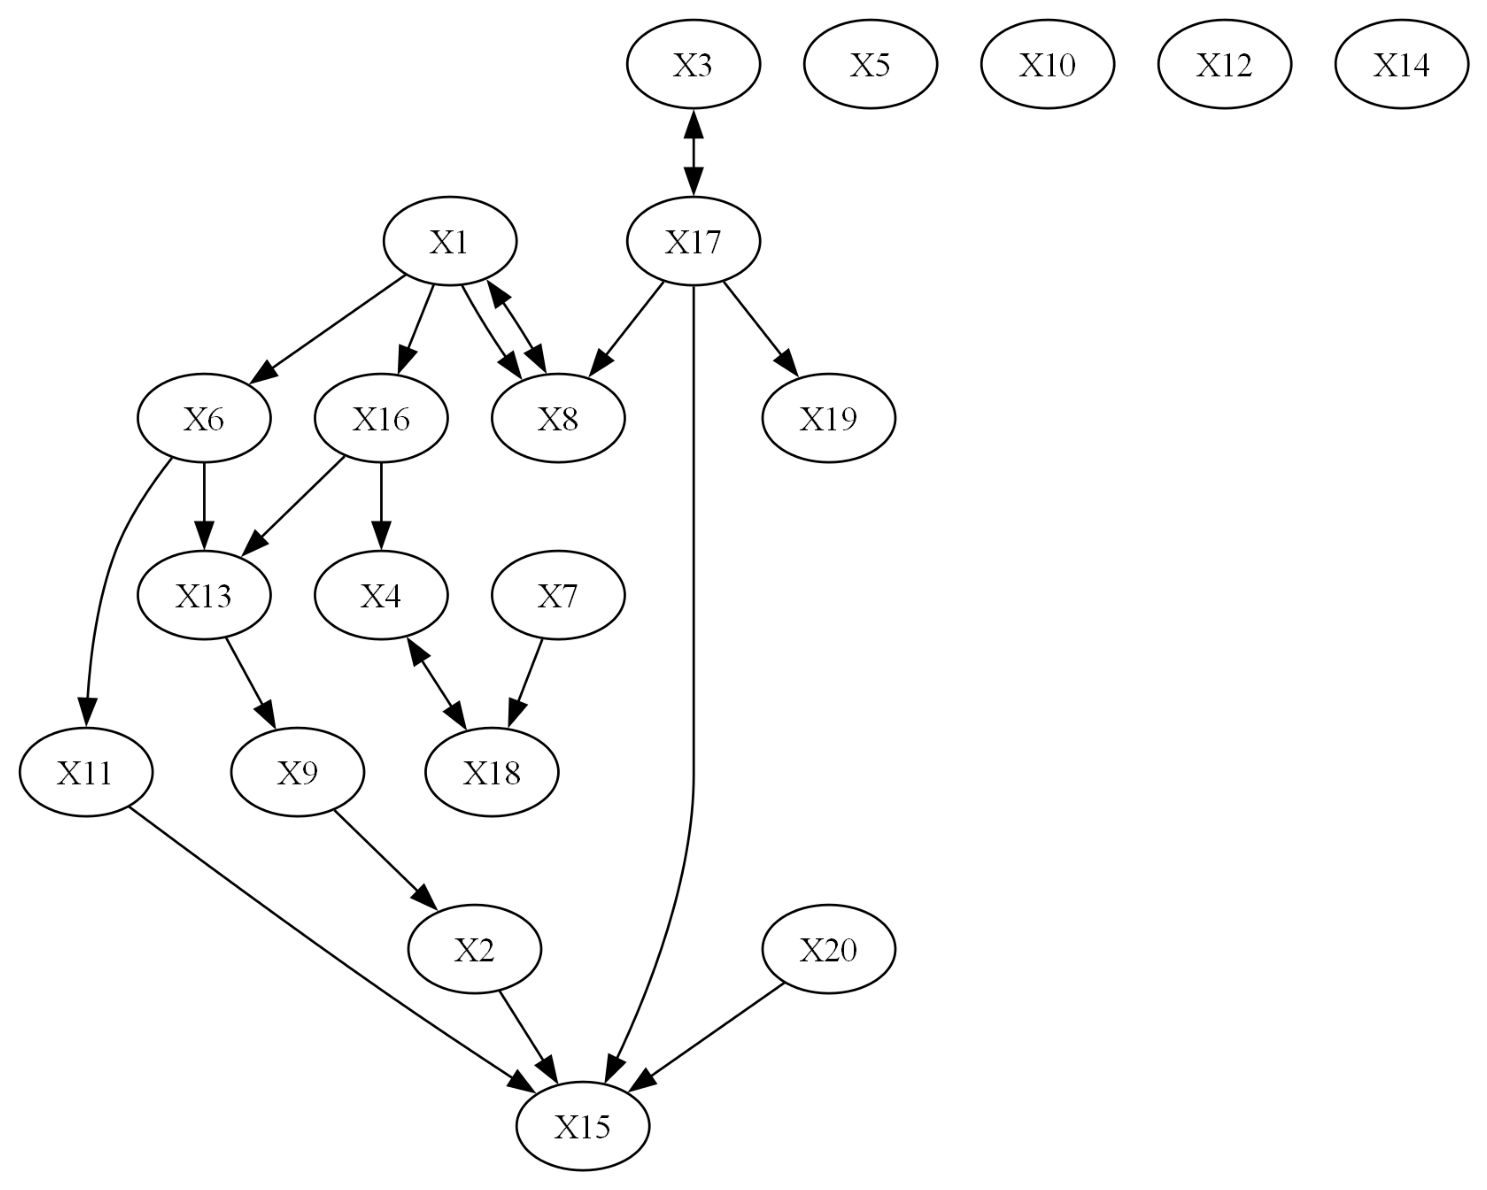

In [42]:
cluster_dag.true_dag.draw_pydot_graph()

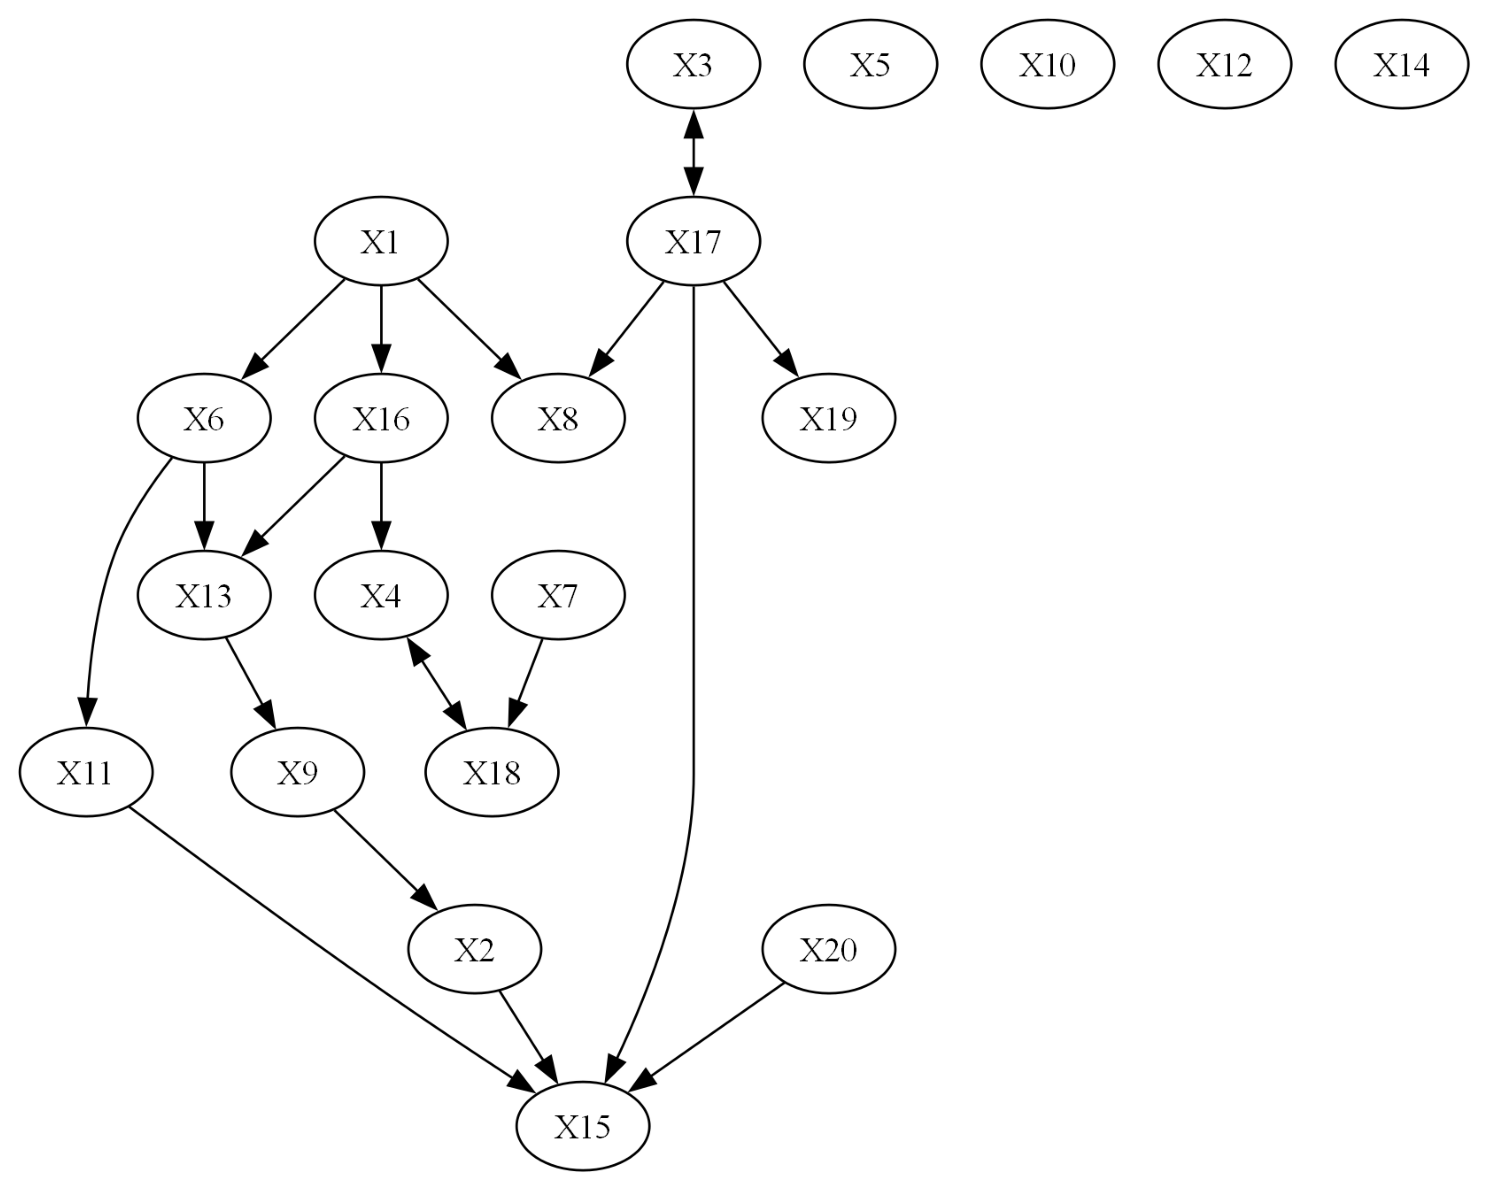

In [43]:
cluster_dag.true_mag.draw_pydot_graph()

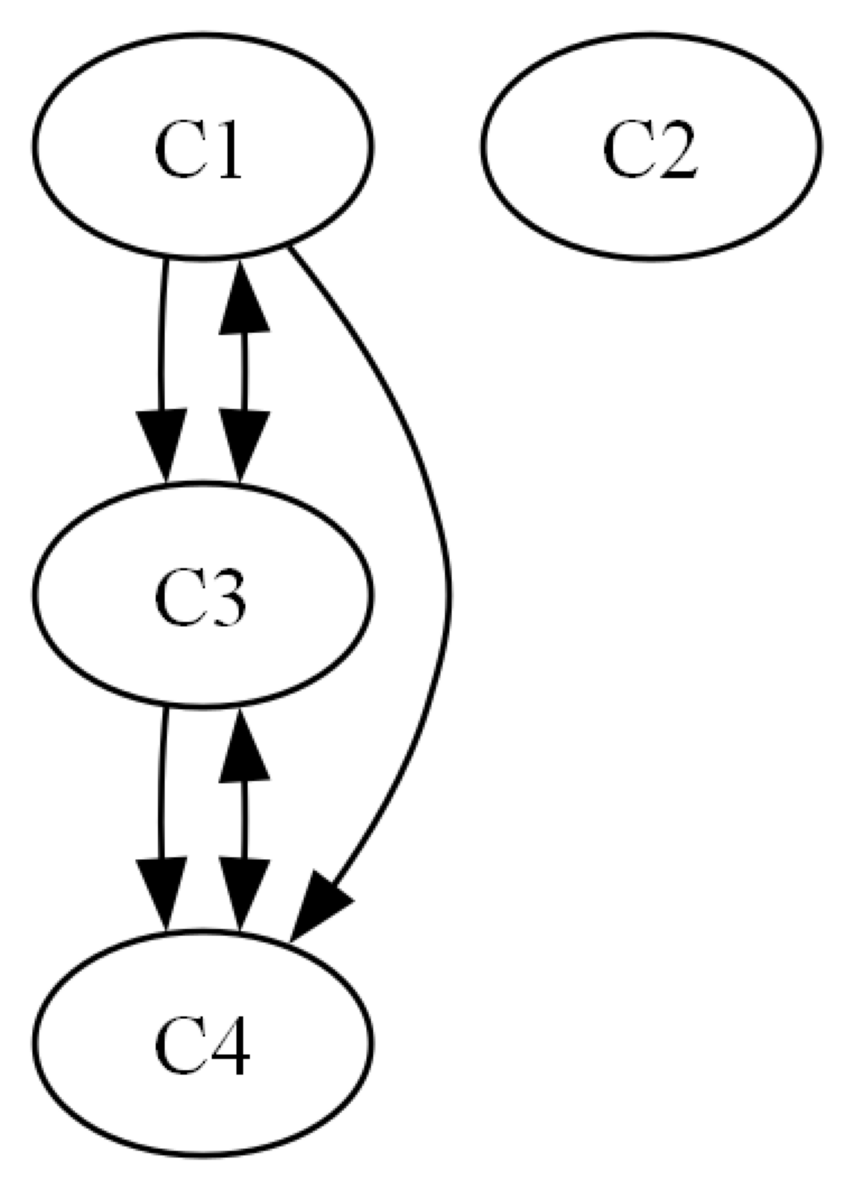

In [44]:
cluster_dag.cluster_graph.draw_pydot_graph()

In [45]:
# cluster_dag.cdag_to_circle_mpdag()
# cluster_dag.cg.draw_pydot_graph()

In [46]:
cluster_dag.cluster_mapping

{'C1': ['X1', 'X7', 'X17', 'X20', 'X3', 'X5', 'X10'],
 'C2': ['X12'],
 'C3': ['X14', 'X6', 'X16', 'X18', 'X8', 'X19', 'X11'],
 'C4': ['X4', 'X13', 'X9', 'X2', 'X15']}

### Evaluate

In [47]:
cluster_fci = ClusterFCI(cluster_dag, dataset = cluster_dag.data, alpha = 0.05)
cluster_cg, cluster_edges = cluster_fci.run()

C4 phase, Depth=4, working on node 14: 100%|██████████| 5/5 [00:00<00:00, 318.37it/s, duration: 0.05sec]

X2 --> X9
X11 --> X2
X14 --> X2
X15 --> X4
X11 --> X14
X15 --> X13


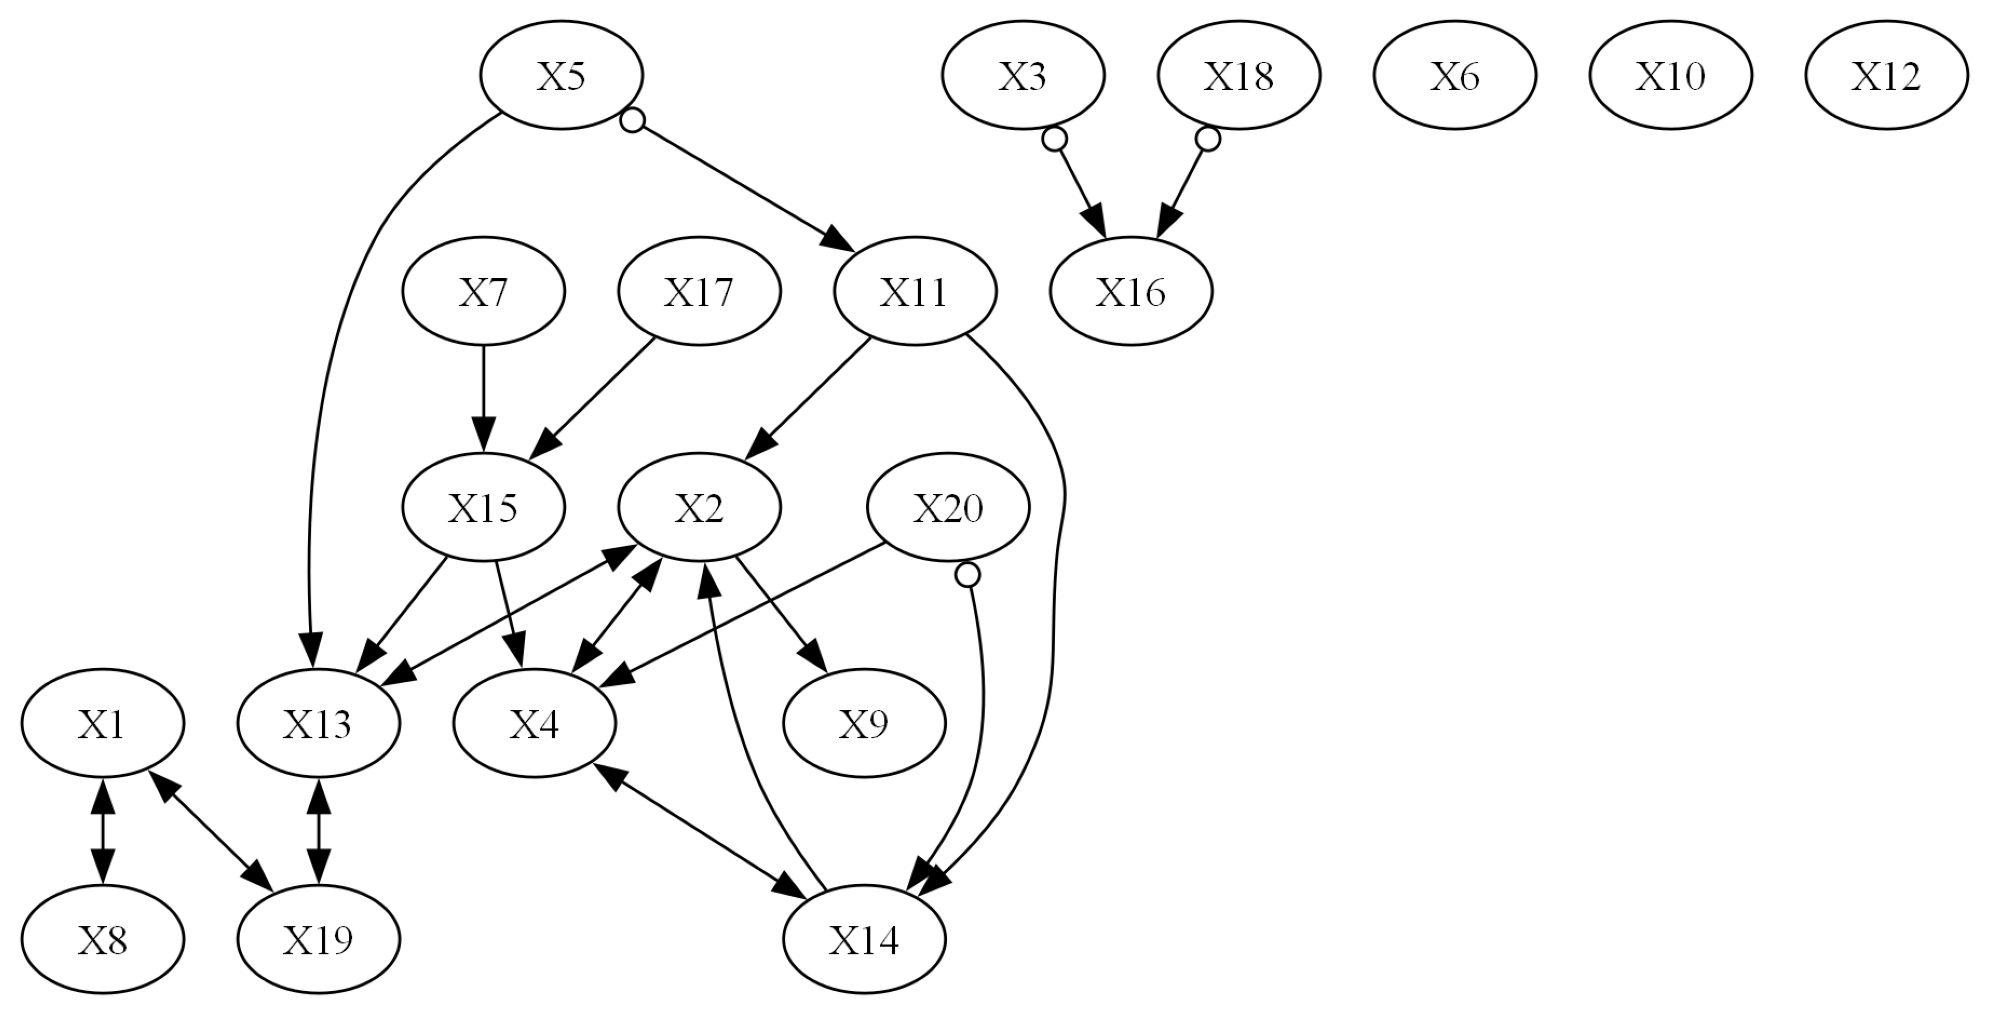

In [48]:
cluster_cg.draw_pydot_graph()

In [49]:
base_G, base_edges = fci(dataset = cluster_dag.data, alpha = 0.05, verbose = False)
base_cg = CausalGraph(len(base_G.get_node_names()))
base_cg.G = base_G

Depth=4, working on node 19: 100%|██████████| 20/20 [00:00<00:00, 1362.78it/s]

X2 --> X9
X14 --> X20


In [53]:
tiers = cluster_dag.get_cluster_topological_ordering()
cluster_mapping = cluster_dag.cluster_mapping
fci_tiers_cg, fci_tiers_edges = fci_tiers(tiers = tiers, \
                                          cluster_mapping = cluster_mapping, \
                                          cdag = cluster_dag, \
                                            dataset = cluster_dag.data, alpha = 0.05, \
                                                verbose = False)

Depth=4, working on node 19: 100%|██████████| 20/20 [00:00<00:00, 1204.71it/s]


X2 --> X9
X11 --> X2
X14 --> X2
X14 --> X4
X15 --> X4
X11 --> X14
X15 --> X13
X19 --> X13


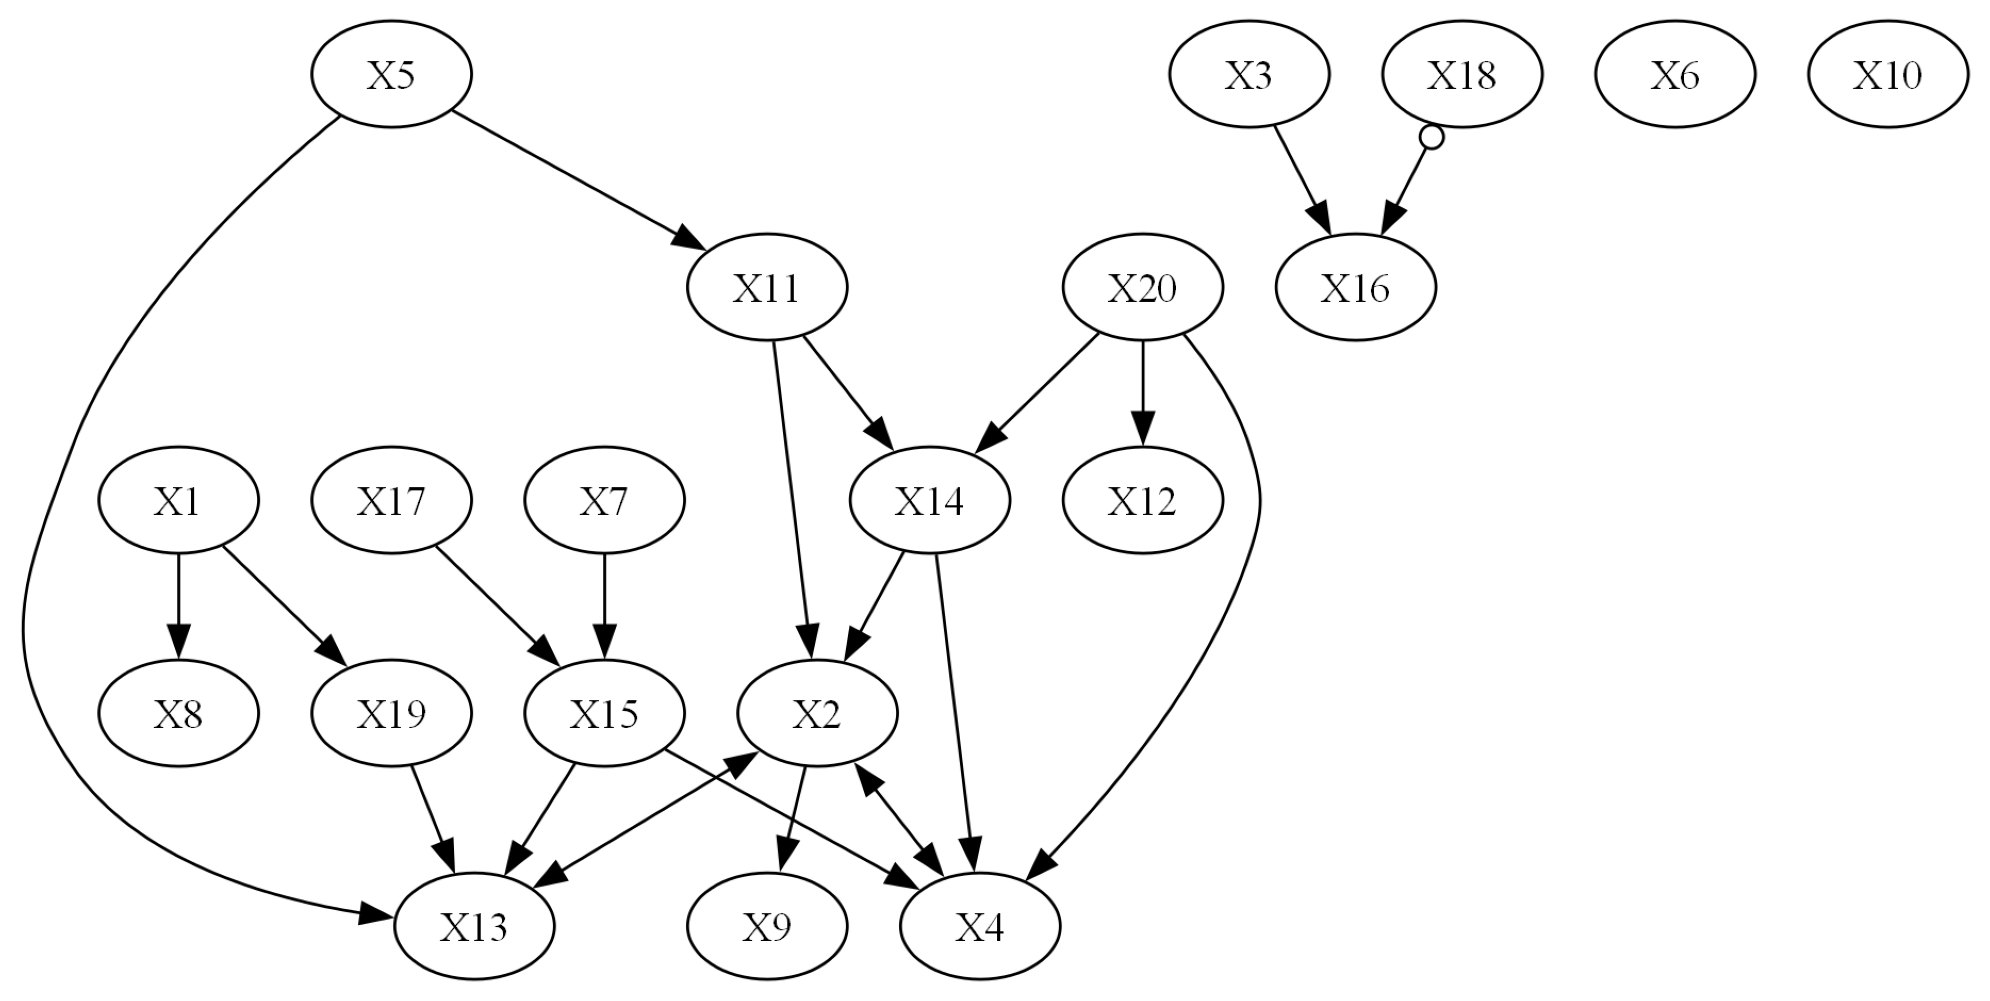

In [54]:
fci_tiers_cg.draw_pydot_graph()

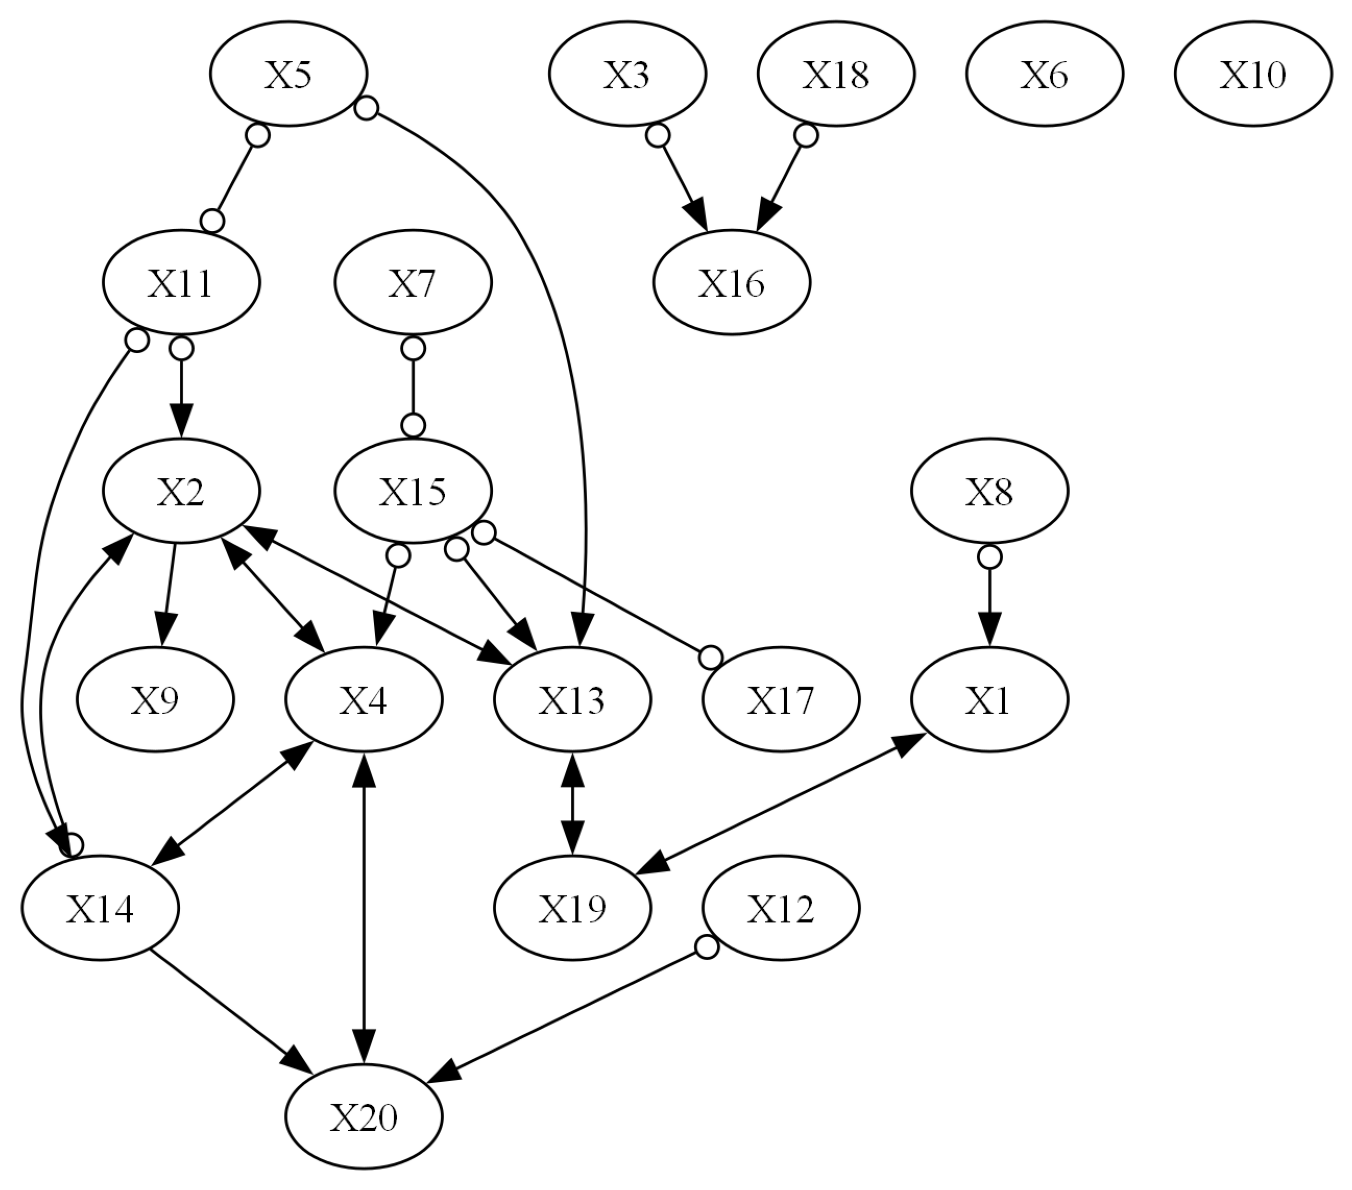

In [55]:
base_cg.draw_pydot_graph()

In [56]:
# Evaluator works on the GeneralGraph object of a CausalGraph object, which is cg.G, cluster_dag.true_dag.G or pc_est_graph.G
eval_fci = Evaluator(truth = cluster_dag.true_mag.G, est = base_cg.G)
adjacency_confusion, arrow_confusion, shd, sid = eval_fci.get_causallearn_metrics(sid = False)
print("Adjacency confusion: ", adjacency_confusion)
print("Arrow confusion: ", arrow_confusion)
print("SHD: ", shd)
print("SID: ",  sid)

Adjacency confusion:  {'true_positive': 3, 'false_positive': 18, 'false_negative': 15, 'true_negative': 154, 'precision': 0.14285714285714285, 'recall': 0.16666666666666666, 'f1_score': 0.15384615384615383}
Arrow confusion:  {'true_positive': 0.0, 'false_positive': 24.0, 'false_negative': 20.0, 'true_negative': 356.0, 'precision': 0.0, 'recall': 0.0, 'f1_score': 0, 'true_positive_ce': 0.0, 'false_positive_ce': 2.0, 'false_negative_ce': 3.0, 'true_negative_ce': 395.0, 'precision_ce': 0.0, 'recall_ce': 0.0, 'f1_score_ce': 0}
SHD:  35
SID:  {'sid_lower': None}


In [57]:
# Evaluator works on the GeneralGraph object of a CausalGraph object, which is cg.G, cluster_dag.true_dag.G or pc_est_graph.G
eval_c_fci = Evaluator(truth = cluster_dag.true_mag.G, est = cluster_cg.G)
adjacency_confusion, arrow_confusion, shd, sid = eval_c_fci.get_causallearn_metrics(sid = False)
print("Adjacency confusion: ", adjacency_confusion)
print("Arrow confusion: ", arrow_confusion)
print("SHD: ", shd)
print("SID: ",  sid)

Adjacency confusion:  {'true_positive': 3, 'false_positive': 17, 'false_negative': 15, 'true_negative': 155, 'precision': 0.15, 'recall': 0.16666666666666666, 'f1_score': 0.15789473684210525}
Arrow confusion:  {'true_positive': 2.0, 'false_positive': 24.0, 'false_negative': 18.0, 'true_negative': 356.0, 'precision': 0.07692307692307693, 'recall': 0.1, 'f1_score': 0.08695652173913043, 'true_positive_ce': 2.0, 'false_positive_ce': 2.0, 'false_negative_ce': 1.0, 'true_negative_ce': 395.0, 'precision_ce': 0.5, 'recall_ce': 0.6666666666666666, 'f1_score_ce': 0.5714285714285715}
SHD:  34
SID:  {'sid_lower': None}


In [58]:
# Evaluator works on the GeneralGraph object of a CausalGraph object, which is cg.G, cluster_dag.true_dag.G or pc_est_graph.G
eval_c_fci = Evaluator(truth = cluster_dag.true_mag.G, est = fci_tiers_cg.G)
adjacency_confusion, arrow_confusion, shd, sid = eval_c_fci.get_causallearn_metrics(sid = False)
print("Adjacency confusion: ", adjacency_confusion)
print("Arrow confusion: ", arrow_confusion)
print("SHD: ", shd)
print("SID: ",  sid)

Adjacency confusion:  {'true_positive': 3, 'false_positive': 18, 'false_negative': 15, 'true_negative': 154, 'precision': 0.14285714285714285, 'recall': 0.16666666666666666, 'f1_score': 0.15384615384615383}
Arrow confusion:  {'true_positive': 2.0, 'false_positive': 21.0, 'false_negative': 18.0, 'true_negative': 359.0, 'precision': 0.08695652173913043, 'recall': 0.1, 'f1_score': 0.09302325581395349, 'true_positive_ce': 2.0, 'false_positive_ce': 1.0, 'false_negative_ce': 1.0, 'true_negative_ce': 396.0, 'precision_ce': 0.6666666666666666, 'recall_ce': 0.6666666666666666, 'f1_score_ce': 0.6666666666666666}
SHD:  34
SID:  {'sid_lower': None}


### Run gridsearch

In [85]:
config_path = 'clustercausal\experiments\configs\cluster_vsfcitiers.yaml'
config_path = config_path.replace('\\', '/')
experiment = ExperimentRunner(config_path)
experiment.run_gridsearch_experiment()

INFO: Finished synthetic dataset
invalid value encountered in divide


Number of experiments: 90


Depth=4, working on node 14: 100%|██████████| 15/15 [00:00<?, ?it/s]          
INFO: Finished synthetic dataset


X8 --> X15


Depth=3, working on node 14: 100%|██████████| 15/15 [00:00<?, ?it/s]          
INFO: Finished synthetic dataset


X8 --> X15


Depth=1, working on node 14: 100%|██████████| 15/15 [00:00<00:00, 20119.78it/s]
invalid value encountered in double_scalars


INFO: Finished synthetic dataset



X14 --> X6
X12 --> X13
X14 --> X15


Depth=3, working on node 14: 100%|██████████| 15/15 [00:00<?, ?it/s]         


X6 --> X3
X14 --> X6
X12 --> X13
X14 --> X15


Depth=3, working on node 14: 100%|██████████| 15/15 [00:00<?, ?it/s]         
invalid value encountered in double_scalars
INFO: Finished synthetic dataset


X14 --> X6
X9 --> X13
X12 --> X13
X14 --> X15
X6 --> X3
X14 --> X6
X12 --> X13
X14 --> X15
X9 --> X8
X11 --> X8
X12 --> X8
X9 --> X11
X14 --> X12


Depth=3, working on node 14: 100%|██████████| 15/15 [00:00<?, ?it/s]          


X9 --> X8
X11 --> X8
X9 --> X11


Depth=3, working on node 14: 100%|██████████| 15/15 [00:00<00:00, 889.70it/s]


X11 --> X8
X12 --> X8
X14 --> X12


INFO: Finished synthetic dataset


X9 --> X8
X11 --> X8
X9 --> X11
X4 --> X11
X6 --> X8
X12 --> X8


Depth=2, working on node 14: 100%|██████████| 15/15 [00:00<00:00, 11958.67it/s]


X6 --> X8
X12 --> X8


Depth=2, working on node 14: 100%|██████████| 15/15 [00:00<00:00, 5533.38it/s]
INFO: Finished synthetic dataset


X4 --> X11
X6 --> X8
X12 --> X8
X6 --> X8
X12 --> X8
X12 --> X1
X8 --> X3
X12 --> X15


Depth=2, working on node 14: 100%|██████████| 15/15 [00:00<00:00, 1734.38it/s]


X2 --> X6
X8 --> X3


Depth=2, working on node 14: 100%|██████████| 15/15 [00:00<?, ?it/s]         
INFO: Finished synthetic dataset


X12 --> X1
X8 --> X3
X12 --> X15
X2 --> X6
X8 --> X3


Depth=1, working on node 14: 100%|██████████| 15/15 [00:00<00:00, 1609.93it/s]
INFO: Finished synthetic dataset


X8 --> X4


Depth=2, working on node 14: 100%|██████████| 15/15 [00:00<00:00, 920.42it/s]
INFO: Finished synthetic dataset


X8 --> X4
X1 --> X12
X9 --> X10


Depth=3, working on node 14: 100%|██████████| 15/15 [00:00<?, ?it/s]           


X1 --> X12
X9 --> X10
X13 --> X11


Depth=3, working on node 14: 100%|██████████| 15/15 [00:00<00:00, 902.03it/s]


X1 --> X12
X9 --> X10


INFO: Finished synthetic dataset


X1 --> X12
X9 --> X10
X13 --> X11
X2 --> X5
X12 --> X10


Depth=2, working on node 14: 100%|██████████| 15/15 [00:00<00:00, 1105.41it/s]


X12 --> X10


Depth=2, working on node 14: 100%|██████████| 15/15 [00:00<?, ?it/s]          


X1 --> X10
X2 --> X5
X12 --> X10


INFO: Finished synthetic dataset


X12 --> X10


Depth=3, working on node 14: 100%|██████████| 15/15 [00:00<00:00, 770.39it/s]
INFO: Finished synthetic dataset


X11 --> X5


Depth=2, working on node 14: 100%|██████████| 15/15 [00:00<?, ?it/s]         
INFO: Finished synthetic dataset


X13 --> X7


Depth=2, working on node 14: 100%|██████████| 15/15 [00:00<?, ?it/s]          
INFO: Finished synthetic dataset


X1 --> X3
X9 --> X1
X1 --> X11
X15 --> X3
X9 --> X10


Depth=2, working on node 14: 100%|██████████| 15/15 [00:00<00:00, 900.50it/s] 


X9 --> X3


Depth=2, working on node 14: 100%|██████████| 15/15 [00:00<?, ?it/s]         
INFO: Finished synthetic dataset


X7 --> X2
X9 --> X3
X2 --> X15
X3 --> X11
X5 --> X4
X4 --> X9
X5 --> X6
X8 --> X5
X5 --> X12
X5 --> X13
X5 --> X14


Depth=4, working on node 14: 100%|██████████| 15/15 [00:00<00:00, 900.46it/s] 


X4 --> X3
X6 --> X3
X3 --> X11
X5 --> X4
X4 --> X9
X4 --> X12
X5 --> X6
X8 --> X5
X5 --> X14


Depth=4, working on node 14: 100%|██████████| 15/15 [00:00<00:00, 1438.87it/s]
INFO: Finished synthetic dataset


X2 --> X15
X5 --> X4
X6 --> X4
X4 --> X9
X5 --> X6
X5 --> X14
X14 --> X13
X4 --> X3
X6 --> X3
X3 --> X11
X5 --> X4
X4 --> X9
X4 --> X12
X5 --> X6
X8 --> X5
X5 --> X14
X1 --> X6
X6 --> X4


Depth=3, working on node 14: 100%|██████████| 15/15 [00:00<?, ?it/s]          


X3 --> X10
X3 --> X12


Depth=3, working on node 14: 100%|██████████| 15/15 [00:00<00:00, 2151.96it/s]


X1 --> X6
X6 --> X4


INFO: Finished synthetic dataset


X3 --> X10
X3 --> X12
X2 --> X10
X5 --> X8
X7 --> X6
X7 --> X10
X8 --> X14
X10 --> X11


Depth=3, working on node 14: 100%|██████████| 15/15 [00:00<?, ?it/s]          


X8 --> X14
X10 --> X11


Depth=3, working on node 14: 100%|██████████| 15/15 [00:00<00:00, 959.52it/s] 
INFO: Finished synthetic dataset


X2 --> X10
X7 --> X6
X7 --> X10
X8 --> X14
X10 --> X11
X15 --> X10
X15 --> X11
X8 --> X14
X10 --> X11
X9 --> X3
X8 --> X9


Depth=2, working on node 14: 100%|██████████| 15/15 [00:00<00:00, 888.70it/s]
INFO: Finished synthetic dataset


X9 --> X3
X8 --> X9
X6 --> X13
X8 --> X9


Depth=2, working on node 14: 100%|██████████| 15/15 [00:00<00:00, 976.43it/s]  


X6 --> X13


Depth=2, working on node 14: 100%|██████████| 15/15 [00:00<00:00, 6544.74it/s] 


X6 --> X13

INFO: Finished synthetic dataset



X7 --> X15
X15 --> X12


Depth=2, working on node 14: 100%|██████████| 15/15 [00:00<?, ?it/s]          
INFO: Finished synthetic dataset


X15 --> X12
X7 --> X10


Depth=4, working on node 14: 100%|██████████| 15/15 [00:00<?, ?it/s]         
INFO: Finished synthetic dataset


X5 --> X8
X5 --> X9
X14 --> X1
X3 --> X2
X3 --> X7
X3 --> X10
X10 --> X6
X13 --> X6
X13 --> X10
X13 --> X14


Depth=4, working on node 14: 100%|██████████| 15/15 [00:00<?, ?it/s]          


X5 --> X6
X10 --> X5


Depth=4, working on node 14: 100%|██████████| 15/15 [00:00<00:00, 901.51it/s] 
INFO: Finished synthetic dataset


X12 --> X2
X4 --> X10
X4 --> X11
X13 --> X4
X13 --> X6
X11 --> X8
X13 --> X10
X5 --> X6
X10 --> X5
X1 --> X10
X3 --> X14
X5 --> X6
X7 --> X5
X8 --> X6
X10 --> X8


Depth=3, working on node 14: 100%|██████████| 15/15 [00:00<00:00, 846.78it/s]  


X3 --> X2


Depth=3, working on node 14: 100%|██████████| 15/15 [00:00<?, ?it/s]         
INFO: Finished synthetic dataset


X1 --> X10
X5 --> X6
X7 --> X5
X8 --> X6
X10 --> X8
X3 --> X2
X12 --> X10
X12 --> X14


Depth=3, working on node 14: 100%|██████████| 15/15 [00:00<00:00, 1665.82it/s]


X9 --> X1


Depth=3, working on node 14: 100%|██████████| 15/15 [00:00<?, ?it/s]           
INFO: Finished synthetic dataset


X12 --> X10
X12 --> X14
X9 --> X1
X3 --> X14
X7 --> X4
X6 --> X15
X7 --> X9
X7 --> X10
X12 --> X10


Depth=2, working on node 14: 100%|██████████| 15/15 [00:00<00:00, 878.22it/s]
INFO: Finished synthetic dataset


X3 --> X10
X3 --> X14
X1 --> X4
X9 --> X13


Depth=3, working on node 14: 100%|██████████| 15/15 [00:00<?, ?it/s]          
INFO: Finished synthetic dataset


X5 --> X6
X9 --> X13
X1 --> X4
X4 --> X9
X4 --> X15


Depth=3, working on node 14: 100%|██████████| 15/15 [00:00<?, ?it/s]          


X1 --> X13
X5 --> X8
X5 --> X15


Depth=3, working on node 14: 100%|██████████| 15/15 [00:00<?, ?it/s]          
INFO: Finished synthetic dataset


X4 --> X9
X4 --> X15
X5 --> X7
X5 --> X8
X5 --> X15
X7 --> X8
X1 --> X13
X5 --> X8
X5 --> X15


Depth=1, working on node 14: 100%|██████████| 15/15 [00:00<?, ?it/s]          
INFO: Finished synthetic dataset


X3 --> X7
X5 --> X4
X4 --> X9
X5 --> X11


Depth=4, working on node 14: 100%|██████████| 15/15 [00:00<?, ?it/s]         
INFO: Finished synthetic dataset


X7 --> X4
X4 --> X9
X7 --> X14
X8 --> X11


Depth=2, working on node 14: 100%|██████████| 15/15 [00:00<00:00, 915.11it/s] 
INFO: Finished synthetic dataset


X2 --> X9
X15 --> X7
X15 --> X14


Depth=2, working on node 14: 100%|██████████| 15/15 [00:00<00:00, 918.90it/s]


X2 --> X9


Depth=2, working on node 14: 100%|██████████| 15/15 [00:00<?, ?it/s]          

X2 --> X9
X15 --> X7
X15 --> X14



INFO: Finished synthetic dataset


X2 --> X9
X6 --> X3


Depth=3, working on node 14: 100%|██████████| 15/15 [00:00<00:00, 808.85it/s]


X6 --> X3


INFO: Finished synthetic dataset


X5 --> X2
X14 --> X5
X7 --> X10
X7 --> X14
X7 --> X15
X14 --> X9


Depth=3, working on node 14: 100%|██████████| 15/15 [00:00<?, ?it/s]         


X5 --> X2


Depth=3, working on node 14: 100%|██████████| 15/15 [00:00<?, ?it/s]          


X5 --> X2
X14 --> X5
X7 --> X10
X7 --> X14
X7 --> X15
X14 --> X9
X5 --> X2


INFO: Finished synthetic dataset


Depth=4, working on node 14: 100%|██████████| 15/15 [00:00<00:00, 14672.24it/s]
INFO: Finished synthetic dataset


X5 --> X8
X2 --> X11
X5 --> X13
X11 --> X9
X11 --> X13


Depth=3, working on node 14: 100%|██████████| 15/15 [00:00<?, ?it/s]          


X2 --> X11
X5 --> X13
X11 --> X9
X11 --> X13


Depth=3, working on node 14: 100%|██████████| 15/15 [00:00<00:00, 816.45it/s]
INFO: Finished synthetic dataset


X2 --> X11
X4 --> X6
X5 --> X13
X9 --> X6
X14 --> X6
X11 --> X9
X11 --> X13
X2 --> X11
X5 --> X13
X11 --> X9
X11 --> X13
X5 --> X3
X6 --> X8
X6 --> X11


Depth=4, working on node 14: 100%|██████████| 15/15 [00:00<?, ?it/s]          


X2 --> X9
X5 --> X3


Depth=3, working on node 14: 100%|██████████| 15/15 [00:00<00:00, 7984.08it/s]


X5 --> X3
X6 --> X8
X6 --> X11


INFO: Finished synthetic dataset


X2 --> X9
X5 --> X3


Depth=3, working on node 14: 100%|██████████| 15/15 [00:00<?, ?it/s]          


X3 --> X4


Depth=3, working on node 14: 100%|██████████| 15/15 [00:00<?, ?it/s]          
INFO: Finished synthetic dataset


X3 --> X15
X3 --> X4
X14 --> X1
X4 --> X5
X4 --> X9
X4 --> X14


Depth=4, working on node 14: 100%|██████████| 15/15 [00:00<?, ?it/s]          


X14 --> X1
X4 --> X5
X4 --> X9
X4 --> X14


Depth=4, working on node 14: 100%|██████████| 15/15 [00:00<?, ?it/s]          


X14 --> X1
X4 --> X5
X4 --> X9
X4 --> X14
X14 --> X1

INFO: Finished synthetic dataset



X4 --> X5
X4 --> X9
X4 --> X14
X5 --> X2
X5 --> X14
X6 --> X11
X13 --> X6


Depth=4, working on node 14: 100%|██████████| 15/15 [00:00<00:00, 687.51it/s] 


X5 --> X2
X4 --> X9
X4 --> X15
X5 --> X14
X6 --> X11
X13 --> X6


Depth=4, working on node 14: 100%|██████████| 15/15 [00:00<?, ?it/s]         
INFO: Finished synthetic dataset


X5 --> X2
X5 --> X14
X6 --> X11
X13 --> X6
X5 --> X2
X4 --> X9
X4 --> X15
X5 --> X14
X6 --> X11
X13 --> X6


Depth=4, working on node 14: 100%|██████████| 15/15 [00:00<00:00, 1360.49it/s]
INFO: Finished synthetic dataset


X13 --> X3
X6 --> X5
X13 --> X5
X5 --> X14
X6 --> X11
X6 --> X15
X11 --> X7
X14 --> X7
X9 --> X13


Depth=4, working on node 14: 100%|██████████| 15/15 [00:00<00:00, 2322.51it/s]


X13 --> X3
X13 --> X5
X9 --> X13


Depth=4, working on node 14: 100%|██████████| 15/15 [00:00<00:00, 1762.41it/s]
INFO: Finished synthetic dataset


X6 --> X5
X5 --> X14
X6 --> X11
X6 --> X15
X11 --> X7
X14 --> X7
X13 --> X3
X13 --> X5
X9 --> X13
X8 --> X3
X9 --> X7
X11 --> X15
X12 --> X13
X12 --> X15


Depth=3, working on node 14: 100%|██████████| 15/15 [00:00<?, ?it/s]          
INFO: Finished synthetic dataset


X1 --> X15
X8 --> X3
X8 --> X7
X11 --> X15
X12 --> X13
X12 --> X15
X1 --> X6
X3 --> X12
X3 --> X13
X5 --> X12
X15 --> X5
X6 --> X11
X7 --> X13
X15 --> X8
X13 --> X11
X15 --> X14


Depth=3, working on node 14: 100%|██████████| 15/15 [00:00<?, ?it/s]          

X13 --> X11

Depth=3, working on node 14: 100%|██████████| 15/15 [00:00<00:00, 905.14it/s] 


X1 --> X6
X3 --> X12
X3 --> X13
X5 --> X12
X6 --> X11
X7 --> X13
X13 --> X11


INFO: Finished synthetic dataset


X13 --> X11
X6 --> X4
X8 --> X6


Depth=3, working on node 14: 100%|██████████| 15/15 [00:00<?, ?it/s]          
INFO: Finished synthetic dataset


X6 --> X4
X12 --> X10
X3 --> X11
X15 --> X13


Depth=4, working on node 14: 100%|██████████| 15/15 [00:00<00:00, 893.80it/s]


X3 --> X11


Depth=4, working on node 14: 100%|██████████| 15/15 [00:00<?, ?it/s]          
INFO: Finished synthetic dataset


X3 --> X6
X3 --> X11
X12 --> X6
X14 --> X6
X3 --> X11
X1 --> X6


Depth=3, working on node 14: 100%|██████████| 15/15 [00:00<?, ?it/s]         


X15 --> X8


Depth=3, working on node 14: 100%|██████████| 15/15 [00:00<00:00, 877.00it/s]
INFO: Finished synthetic dataset


X1 --> X6
X5 --> X7
X5 --> X14
X15 --> X8
X3 --> X10
X15 --> X3
X13 --> X6
X15 --> X6


Depth=2, working on node 14: 100%|██████████| 15/15 [00:00<?, ?it/s]         


X3 --> X10
X15 --> X3
X10 --> X8


Depth=3, working on node 14: 100%|██████████| 15/15 [00:00<?, ?it/s]          


X3 --> X10
X15 --> X3
X13 --> X6
X15 --> X6


INFO: Finished synthetic dataset


X3 --> X10
X15 --> X3
X10 --> X8
X13 --> X5
X7 --> X15
X13 --> X9


Depth=3, working on node 14: 100%|██████████| 15/15 [00:00<?, ?it/s]          


X7 --> X15


Depth=3, working on node 14: 100%|██████████| 15/15 [00:00<00:00, 790.74it/s]
INFO: Finished synthetic dataset


X14 --> X2
X4 --> X8
X4 --> X10
X4 --> X14
X13 --> X5
X11 --> X8
X11 --> X9
X13 --> X9
X7 --> X15
X15 --> X4
X5 --> X7
X8 --> X13
X9 --> X13


Depth=3, working on node 14: 100%|██████████| 15/15 [00:00<00:00, 904.24it/s] 
INFO: Finished synthetic dataset


X2 --> X11
X5 --> X7
X8 --> X13
X11 --> X2


Depth=4, working on node 14: 100%|██████████| 15/15 [00:00<00:00, 11055.10it/s]


X1 --> X2
X6 --> X1


Depth=4, working on node 14: 100%|██████████| 15/15 [00:00<00:00, 10485.76it/s]
INFO: Finished synthetic dataset


X11 --> X2
X1 --> X2
X6 --> X1
X7 --> X6


Depth=3, working on node 14: 100%|██████████| 15/15 [00:00<?, ?it/s]         


X6 --> X13


Depth=3, working on node 14: 100%|██████████| 15/15 [00:00<?, ?it/s]         
INFO: Finished synthetic dataset


X7 --> X6
X6 --> X13
X6 --> X15
X6 --> X13
X11 --> X2
X14 --> X2


Depth=3, working on node 14: 100%|██████████| 15/15 [00:00<00:00, 812.44it/s]


X7 --> X1
X5 --> X7
X5 --> X10
X15 --> X5


Depth=3, working on node 14: 100%|██████████| 15/15 [00:00<?, ?it/s]         
INFO: Finished synthetic dataset


X12 --> X2
X7 --> X1
X5 --> X7
X5 --> X10
X15 --> X5
X12 --> X5
X12 --> X13
X15 --> X13


Depth=3, working on node 14: 100%|██████████| 15/15 [00:00<00:00, 906.42it/s]
INFO: Finished synthetic dataset


X11 --> X13
X15 --> X13
X2 --> X12
X14 --> X3
X12 --> X4
X13 --> X14


Depth=5, working on node 14: 100%|██████████| 15/15 [00:00<00:00, 934.43it/s]


X14 --> X3


Depth=5, working on node 14: 100%|██████████| 15/15 [00:00<00:00, 1038.18it/s]
INFO: Finished synthetic dataset


X14 --> X1
X14 --> X3
X12 --> X4
X13 --> X14
X14 --> X3
X6 --> X14


Depth=3, working on node 14: 100%|██████████| 15/15 [00:00<?, ?it/s]          


X5 --> X2
X13 --> X2
X6 --> X9
X6 --> X14


Depth=3, working on node 14: 100%|██████████| 15/15 [00:00<?, ?it/s]         
INFO: Finished synthetic dataset


X5 --> X4
X4 --> X11
X5 --> X12
X6 --> X14
X13 --> X7
X12 --> X10
X13 --> X10
X12 --> X14
X5 --> X2
X13 --> X2
X6 --> X9
X6 --> X14
X3 --> X1
X12 --> X1
X2 --> X9
X10 --> X2
X12 --> X2
X4 --> X3
X11 --> X3
X12 --> X5
X12 --> X6
X11 --> X7
X10 --> X9
X12 --> X9
X12 --> X10


Depth=3, working on node 14: 100%|██████████| 15/15 [00:00<?, ?it/s]          


X1 --> X12
X9 --> X2
X9 --> X12


Depth=3, working on node 14: 100%|██████████| 15/15 [00:00<00:00, 933.41it/s] 
INFO: Finished synthetic dataset


X1 --> X6
X1 --> X7
X2 --> X9
X10 --> X2
X4 --> X3
X11 --> X3
X11 --> X7
X10 --> X9
X1 --> X12
X9 --> X2
X9 --> X12
X14 --> X2
X14 --> X8
X15 --> X8
X10 --> X9
X15 --> X14


Depth=3, working on node 14: 100%|██████████| 15/15 [00:00<00:00, 2286.64it/s] 
INFO: Finished synthetic dataset


X14 --> X2
X14 --> X8
X15 --> X8
X15 --> X14
X7 --> X9
X7 --> X10
X10 --> X8
X11 --> X12
X11 --> X14
X14 --> X12


Depth=2, working on node 14: 100%|██████████| 15/15 [00:00<00:00, 1131.98it/s]


X2 --> X1
X11 --> X2
X2 --> X15
X3 --> X7
X3 --> X9
X15 --> X3
X15 --> X4
X7 --> X10
X14 --> X7
X10 --> X8
X12 --> X11


Depth=2, working on node 14: 100%|██████████| 15/15 [00:00<00:00, 12441.08it/s]
INFO: Finished synthetic dataset


X9 --> X3
X10 --> X8
X11 --> X12
X11 --> X14
X14 --> X12
X2 --> X1
X11 --> X2
X2 --> X15
X3 --> X7
X3 --> X9
X15 --> X3
X15 --> X4
X7 --> X10
X14 --> X7
X10 --> X8
X12 --> X11
X1 --> X4
X1 --> X9
X1 --> X11
X4 --> X9


Depth=4, working on node 14: 100%|██████████| 15/15 [00:00<?, ?it/s]          


X13 --> X1
X2 --> X8
X4 --> X9


Depth=4, working on node 14: 100%|██████████| 15/15 [00:00<?, ?it/s]          
INFO: Finished synthetic dataset


X4 --> X9
X13 --> X6
X13 --> X11
X14 --> X12
X13 --> X1
X2 --> X8
X4 --> X9
X4 --> X10
X4 --> X11
X5 --> X12
X12 --> X14


Depth=3, working on node 14: 100%|██████████| 15/15 [00:00<?, ?it/s]          
INFO: Finished synthetic dataset


X5 --> X12
X12 --> X14
X10 --> X1
X3 --> X12
X6 --> X5


Depth=3, working on node 14: 100%|██████████| 15/15 [00:00<?, ?it/s]         


X10 --> X1
X3 --> X12
X6 --> X5


Depth=3, working on node 14: 100%|██████████| 15/15 [00:00<?, ?it/s]          


X10 --> X1
X3 --> X12
X6 --> X5


INFO: Finished synthetic dataset


X10 --> X1
X3 --> X12
X6 --> X5
X11 --> X15


Depth=5, working on node 14: 100%|██████████| 15/15 [00:00<?, ?it/s]         


X14 --> X1
X15 --> X8
X11 --> X15


Depth=5, working on node 14: 100%|██████████| 15/15 [00:00<?, ?it/s]         


X10 --> X14

INFO: Finished synthetic dataset



X14 --> X1
X15 --> X8
X11 --> X15
X10 --> X1
X1 --> X13


Depth=3, working on node 14: 100%|██████████| 15/15 [00:00<00:00, 2867.44it/s]


X10 --> X1
X1 --> X13
X13 --> X15


Depth=3, working on node 14: 100%|██████████| 15/15 [00:00<00:00, 963.37it/s] 


X13 --> X15


INFO: Finished synthetic dataset


X10 --> X1
X1 --> X13
X13 --> X15
X1 --> X15
X3 --> X8
X3 --> X10
X5 --> X9
X7 --> X9


Depth=3, working on node 14: 100%|██████████| 15/15 [00:00<00:00, 811.71it/s]


X1 --> X15
X5 --> X9
X7 --> X9
X10 --> X14
X11 --> X14


Depth=3, working on node 14: 100%|██████████| 15/15 [00:00<?, ?it/s]         


X3 --> X8

INFO: Finished synthetic dataset



X3 --> X10
X4 --> X11
X4 --> X15
X5 --> X9
X1 --> X15
X5 --> X9
X7 --> X9
X10 --> X14
X11 --> X14
X1 --> X13
X8 --> X2
X2 --> X10
X8 --> X3
X13 --> X15


Depth=4, working on node 14: 100%|██████████| 15/15 [00:00<00:00, 1084.23it/s] 


X3 --> X1
X1 --> X8
X8 --> X2
X2 --> X10
X3 --> X8
X9 --> X7
X13 --> X15


Depth=4, working on node 14: 100%|██████████| 15/15 [00:00<00:00, 12143.32it/s]
INFO: Finished synthetic dataset


X3 --> X1
X1 --> X8
X8 --> X2
X2 --> X10
X3 --> X8
X9 --> X7
X13 --> X15
X11 --> X1
X13 --> X2
X8 --> X4
X5 --> X8
X11 --> X8


Depth=4, working on node 14: 100%|██████████| 15/15 [00:00<?, ?it/s]          


X11 --> X1
X13 --> X2
X8 --> X4
X7 --> X5
X5 --> X8
X11 --> X7
X11 --> X8


Depth=4, working on node 14: 100%|██████████| 15/15 [00:00<?, ?it/s]           


X11 --> X1
X13 --> X2
X8 --> X4
X5 --> X8
X11 --> X8


INFO: Finished synthetic dataset


X11 --> X1
X13 --> X2
X8 --> X4
X7 --> X5
X5 --> X8
X11 --> X7
X11 --> X8
X1 --> X10
X11 --> X1
X12 --> X2
X14 --> X4
X6 --> X9
X15 --> X7
X15 --> X9


Depth=4, working on node 14: 100%|██████████| 15/15 [00:00<00:00, 937.88it/s] 

X6 --> X9



Depth=4, working on node 14: 100%|██████████| 15/15 [00:00<?, ?it/s]          


X1 --> X10
X11 --> X1
X12 --> X2
X14 --> X4


INFO: Finished synthetic dataset


X6 --> X9
X3 --> X2
X3 --> X10
X3 --> X13
X7 --> X13
X10 --> X15


Depth=3, working on node 14: 100%|██████████| 15/15 [00:00<?, ?it/s]         


X7 --> X13
X10 --> X15


Depth=3, working on node 14: 100%|██████████| 15/15 [00:00<00:00, 928.14it/s]  
INFO: Finished synthetic dataset


X3 --> X2
X3 --> X10
X3 --> X13
X7 --> X13
X10 --> X15
X7 --> X13
X10 --> X15
X12 --> X1
X2 --> X4
X8 --> X9


Depth=3, working on node 14: 100%|██████████| 15/15 [00:00<00:00, 1336.59it/s]


X12 --> X1
X3 --> X12
X7 --> X12


Depth=3, working on node 14: 100%|██████████| 15/15 [00:00<?, ?it/s]          


X12 --> X1
X2 --> X4
X7 --> X12
X8 --> X9


INFO: Finished synthetic dataset


X12 --> X1
X3 --> X12
X7 --> X12
X2 --> X1
X10 --> X1
X1 --> X13
X3 --> X13
X7 --> X5
X8 --> X5
X6 --> X11
X8 --> X7
X8 --> X13
X10 --> X11
X15 --> X14


Depth=5, working on node 14: 100%|██████████| 15/15 [00:00<00:00, 4279.90it/s]


X15 --> X14


Depth=4, working on node 14: 100%|██████████| 15/15 [00:00<?, ?it/s]         
INFO: Finished synthetic dataset


X10 --> X1
X1 --> X13
X7 --> X5
X8 --> X5
X6 --> X11
X8 --> X13
X10 --> X11
X15 --> X14
X10 --> X12


Depth=4, working on node 14: 100%|██████████| 15/15 [00:00<00:00, 11480.76it/s]
INFO: Finished synthetic dataset


X10 --> X12
X1 --> X9
X6 --> X2
X15 --> X3
X7 --> X4
X6 --> X7
X7 --> X15
X15 --> X9


Depth=4, working on node 14: 100%|██████████| 15/15 [00:00<?, ?it/s]          


X1 --> X9
X6 --> X2
X7 --> X4
X4 --> X13
X6 --> X7
X15 --> X13


Depth=4, working on node 14: 100%|██████████| 15/15 [00:00<00:00, 2496.11it/s]
INFO: Finished synthetic dataset


X6 --> X1
X1 --> X9
X11 --> X1
X6 --> X2
X3 --> X5
X6 --> X9
X11 --> X14
X15 --> X13
X1 --> X9
X6 --> X2
X7 --> X4
X4 --> X13
X6 --> X7
X15 --> X13
X12 --> X2
X8 --> X3
X10 --> X3
X5 --> X12
X6 --> X10


Depth=4, working on node 14: 100%|██████████| 15/15 [00:00<00:00, 1314.99it/s]


X1 --> X2
X10 --> X1
X12 --> X2
X10 --> X3
X4 --> X12
X5 --> X12
X5 --> X15
X6 --> X10
X15 --> X7
X14 --> X9
X15 --> X14


Depth=4, working on node 14: 100%|██████████| 15/15 [00:00<00:00, 2167.67it/s] 
INFO: Finished synthetic dataset


X12 --> X2
X8 --> X3
X10 --> X3
X4 --> X5
X4 --> X6
X4 --> X12
X9 --> X5
X5 --> X12
X6 --> X10
X9 --> X7
X9 --> X14
X1 --> X2
X10 --> X1
X12 --> X2
X10 --> X3
X4 --> X12
X5 --> X12
X5 --> X15
X6 --> X10
X15 --> X7
X14 --> X9
X15 --> X14
X5 --> X2
X8 --> X2
X4 --> X5
X9 --> X4
X8 --> X5
X9 --> X5
X6 --> X9
X9 --> X8
X9 --> X12


Depth=3, working on node 14: 100%|██████████| 15/15 [00:00<?, ?it/s]         
INFO: Finished synthetic dataset


X5 --> X2
X4 --> X5
X1 --> X8
X6 --> X2
X2 --> X7
X14 --> X2
X11 --> X4
X5 --> X7
X5 --> X13
X10 --> X6
X14 --> X11


Depth=4, working on node 14: 100%|██████████| 15/15 [00:00<00:00, 2140.82it/s]


X7 --> X5
X5 --> X12
X5 --> X13
X10 --> X6
X13 --> X6
X7 --> X14


Depth=4, working on node 14: 100%|██████████| 15/15 [00:00<?, ?it/s]           
INFO: Finished synthetic dataset


X1 --> X8
X2 --> X7
X5 --> X7
X12 --> X5
X5 --> X13
X6 --> X13
X7 --> X5
X5 --> X12
X5 --> X13
X10 --> X6
X13 --> X6
X7 --> X14
X1 --> X3
X9 --> X1
X6 --> X13


Depth=3, working on node 14: 100%|██████████| 15/15 [00:00<00:00, 2499.98it/s]


X3 --> X6


Depth=3, working on node 14: 100%|██████████| 15/15 [00:00<00:00, 2023.24it/s]


X1 --> X3
X9 --> X1
X13 --> X7
X9 --> X15


INFO: Finished synthetic dataset


X3 --> X6
X6 --> X1
X6 --> X12
X8 --> X15


Depth=4, working on node 14: 100%|██████████| 15/15 [00:00<00:00, 933.38it/s] 


X6 --> X1
X6 --> X12
X8 --> X15


Depth=4, working on node 14: 100%|██████████| 15/15 [00:00<00:00, 911.00it/s]
INFO: Finished synthetic dataset


X6 --> X1
X6 --> X12
X8 --> X15
X2 --> X13
X7 --> X13


Depth=3, working on node 14: 100%|██████████| 15/15 [00:00<00:00, 956.67it/s]


X10 --> X9


Depth=3, working on node 14: 100%|██████████| 15/15 [00:00<00:00, 1151.35it/s]


X2 --> X13
X15 --> X4
X7 --> X13
X10 --> X9


INFO: Finished synthetic dataset


X11 --> X2
X3 --> X13
X4 --> X7
X12 --> X4
X7 --> X5
X10 --> X14
X12 --> X13


Depth=4, working on node 14: 100%|██████████| 15/15 [00:00<00:00, 899.37it/s]  


X13 --> X1
X3 --> X4
X3 --> X13
X4 --> X7
X10 --> X14


Depth=3, working on node 14: 100%|██████████| 15/15 [00:00<00:00, 895.53it/s]  


X1 --> X13
X11 --> X2
X3 --> X4
X3 --> X13
X4 --> X7
X7 --> X5
X11 --> X9
X13 --> X9


INFO: Finished synthetic dataset


X13 --> X1
X3 --> X4
X3 --> X13
X4 --> X7
X10 --> X14
X5 --> X1


Depth=2, working on node 14: 100%|██████████| 15/15 [00:00<00:00, 772.68it/s]  
INFO: Finished synthetic dataset


X5 --> X1
X13 --> X1
X4 --> X3
X3 --> X14
X4 --> X10
X11 --> X5
X11 --> X8
X15 --> X8
X2 --> X13
X10 --> X3
X10 --> X6


Depth=4, working on node 14: 100%|██████████| 15/15 [00:00<00:00, 1066.85it/s]


X13 --> X1
X11 --> X3
X13 --> X11
X14 --> X12
X13 --> X14


Depth=4, working on node 14: 100%|██████████| 15/15 [00:00<00:00, 999.23it/s]  


X1 --> X10
X1 --> X13
X10 --> X3
X10 --> X6
X13 --> X1
X11 --> X3
X13 --> X11
X14 --> X12
X13 --> X14


INFO: Finished synthetic dataset


X5 --> X1
X2 --> X14
X5 --> X8
X9 --> X5
X11 --> X5
X8 --> X7


Depth=4, working on node 14: 100%|██████████| 15/15 [00:00<00:00, 1178.53it/s]


X4 --> X5
X6 --> X4
X4 --> X9
X5 --> X9
X5 --> X12
X10 --> X13
X12 --> X14


Depth=4, working on node 14: 100%|██████████| 15/15 [00:00<00:00, 1090.88it/s]


X5 --> X1
X10 --> X1
X2 --> X14
X9 --> X5
X6 --> X10
X6 --> X15
X4 --> X5
X6 --> X4
X4 --> X9
X5 --> X9
X5 --> X12
X10 --> X13
X12 --> X14


INFO: Finished synthetic dataset


X6 --> X1
X2 --> X5
X6 --> X4
X15 --> X5
X10 --> X7
X13 --> X7
X13 --> X12


Depth=4, working on node 14: 100%|██████████| 15/15 [00:00<00:00, 659.16it/s] 


X6 --> X13
X10 --> X7
X13 --> X7
X13 --> X12


Depth=4, working on node 14: 100%|██████████| 15/15 [00:00<00:00, 1037.46it/s]


X1 --> X3
X2 --> X3
X2 --> X4
X2 --> X5
X6 --> X4
X9 --> X5
X14 --> X5
X15 --> X5
X6 --> X7
X10 --> X6
X15 --> X9
X6 --> X13
X10 --> X7
X13 --> X7
X13 --> X12


INFO: Finished synthetic dataset


X3 --> X6
X5 --> X9


Depth=5, working on node 14: 100%|██████████| 15/15 [00:00<00:00, 117159.33it/s]


X1 --> X9
X3 --> X6
X14 --> X15


Depth=5, working on node 14: 100%|██████████| 15/15 [00:00<00:00, 891.90it/s] 


X4 --> X1
X7 --> X1
X9 --> X1
X3 --> X6
X7 --> X3
X8 --> X4
X5 --> X9
X9 --> X6
X9 --> X7
X9 --> X13
X12 --> X13
X15 --> X12


INFO: Finished synthetic dataset


X1 --> X9
X3 --> X6
X14 --> X15
X1 --> X2
X1 --> X6
X10 --> X1
X13 --> X4
X5 --> X10
X11 --> X7
X7 --> X12
X7 --> X14
X13 --> X10


Depth=4, working on node 14: 100%|██████████| 15/15 [00:00<00:00, 677.57it/s] 


X7 --> X14


Depth=3, working on node 14: 100%|██████████| 15/15 [00:00<00:00, 767.33it/s] 


X1 --> X2
X1 --> X6
X10 --> X1
X4 --> X3
X13 --> X4
X5 --> X10
X11 --> X5
X11 --> X7
X7 --> X12
X7 --> X14


INFO: Finished synthetic dataset


X7 --> X14
X1 --> X12
X14 --> X1
X4 --> X12
X13 --> X6


Depth=4, working on node 14: 100%|██████████| 15/15 [00:00<00:00, 1053.88it/s]


X1 --> X4
X1 --> X14
X8 --> X2
X4 --> X8
X12 --> X4


Depth=4, working on node 14: 100%|██████████| 15/15 [00:00<00:00, 880.10it/s]  


X1 --> X4
X2 --> X7
X4 --> X8
X12 --> X4
X13 --> X6
X1 --> X4
X1 --> X14
X8 --> X2
X4 --> X8
X12 --> X4


INFO: Finished synthetic dataset


X1 --> X8
X1 --> X11
X2 --> X6
X3 --> X4
X14 --> X5
X9 --> X7
X7 --> X15
X14 --> X9
X10 --> X12
X13 --> X15


Depth=4, working on node 14: 100%|██████████| 15/15 [00:00<00:00, 904.66it/s]


X3 --> X2
X5 --> X2
X4 --> X3
X3 --> X15
X4 --> X11
X7 --> X15
X14 --> X9


Depth=4, working on node 14: 100%|██████████| 15/15 [00:00<00:00, 851.05it/s] 


X2 --> X8
X3 --> X4
X3 --> X15
X7 --> X4
X11 --> X4
X8 --> X6
X9 --> X7
X7 --> X15
X9 --> X12
X14 --> X9
X13 --> X15
X14 --> X15


INFO: Finished synthetic dataset


X3 --> X2
X5 --> X2
X4 --> X3
X3 --> X15
X4 --> X11
X7 --> X15
X14 --> X9
X2 --> X12
X3 --> X9
X14 --> X6
X14 --> X8
X15 --> X9
X11 --> X12


Depth=4, working on node 14: 100%|██████████| 15/15 [00:00<00:00, 466.65it/s] 


X1 --> X8
X12 --> X1
X2 --> X12
X10 --> X4
X14 --> X6
X10 --> X8
X14 --> X8
X12 --> X10
X12 --> X11


Depth=4, working on node 14: 100%|██████████| 15/15 [00:00<00:00, 1076.71it/s]


X3 --> X9
X13 --> X9
X15 --> X13
X1 --> X8
X12 --> X1
X2 --> X12
X10 --> X4
X14 --> X6
X10 --> X8
X14 --> X8
X12 --> X10
X12 --> X11


INFO: Finished synthetic dataset


X2 --> X5
X6 --> X2
X2 --> X13
X4 --> X12
X6 --> X10
X10 --> X13
X11 --> X13


Depth=3, working on node 14: 100%|██████████| 15/15 [00:00<00:00, 938.48it/s]


X12 --> X1
X4 --> X12
X5 --> X12
X11 --> X13


Depth=2, working on node 14: 100%|██████████| 15/15 [00:00<00:00, 1119.02it/s]


X4 --> X5
X4 --> X12
X12 --> X5
X5 --> X13
X10 --> X13
X11 --> X13
X12 --> X1
X4 --> X12
X5 --> X12
X11 --> X13


In [86]:
data = load_experiment_folder('clustercausal\experiments\_results')

# Load dataframe directly

# To load the dataframe directly, use
# data = pd.read_pickle('clustercausal\experiments\_results_dataframes_for_simulations\data_clusterFCI_simulation.pkl')


In [87]:
# data_all also contains runs with n_clusters = 1
data_all = data.copy()
# data_all.to_pickle('clustercausal\experiments\_results_storage\data_clusterFCI_simulation.pkl')
# data = data[data['n_clusters'] != 1]
# # To look only at clusterings where at least two clusters were non-adjacent
# data_nonadj_clusters = data[data['cluster_connectivity'] != 1]

In [88]:
data_all.describe()

,base_adj_f1_score,base_adj_false_negative,base_adj_false_positive,base_adj_precision,base_adj_recall,base_adj_true_negative,base_adj_true_positive,base_arrow_f1_score,base_arrow_f1_score_ce,base_arrow_false_negative,...,alpha,cluster_connectivity,empty_graph_shd,n_clusters,n_edges,n_nodes,noise_scale,sample_size,true_sid_lower,true_sid_upper
count,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,81.000000,90.000000,...,9.000000e+01,90.000000,90.000000,90.000000,90.000000,90.0,90.0,90.0,0.0,0.0
mean,0.276185,19.722222,8.422222,0.379549,0.230016,71.311111,5.544444,0.168358,0.636178,28.344444,...,5.000000e-02,0.731111,25.266667,4.000000,26.000000,18.0,1.0,1000.0,NaN,NaN
std,0.169609,11.104233,3.619478,0.219658,0.165126,14.213970,3.786912,0.120974,0.205043,16.529280,...,1.395554e-17,0.251329,13.183067,1.642142,7.525238,0.0,0.0,0.0,NaN,NaN
min,0.000000,0.000000,0.000000,0.000000,0.000000,37.000000,0.000000,0.000000,0.000000,3.000000,...,5.000000e-02,0.133333,3.000000,2.000000,18.000000,18.0,1.0,1000.0,NaN,NaN
25%,0.182875,11.000000,6.000000,0.253289,0.143728,60.250000,2.250000,0.075835,0.500000,15.000000,...,5.000000e-02,0.500000,15.000000,2.000000,18.000000,18.0,1.0,1000.0,NaN,NaN
50%,0.250000,18.000000,8.000000,0.341667,0.196154,72.000000,5.000000,0.164010,0.666667,26.000000,...,5.000000e-02,0.700000,22.500000,4.000000,24.000000,18.0,1.0,1000.0,NaN,NaN
75%,0.347549,26.750000,11.000000,0.522059,0.271212,82.750000,7.000000,0.235294,0.727273,36.750000,...,5.000000e-02,1.000000,34.750000,6.000000,36.000000,18.0,1.0,1000.0,NaN,NaN
max,1.000000,51.000000,17.000000,1.000000,1.000000,100.000000,17.000000,0.571429,1.000000,80.000000,...,5.000000e-02,1.000000,62.000000,6.000000,36.000000,18.0,1.0,1000.0,NaN,NaN


In [89]:
# analyze NA values
data_all.isna().sum()

base_adj_f1_score           0
base_adj_false_negative     0
base_adj_false_positive     0
base_adj_precision          0
base_adj_recall             0
                           ..
scm_method                  0
seed                       90
true_sid_lower             90
true_sid_upper             90
weight_range                0
Length: 111, dtype: int64

In [106]:
print(data_all.columns)

Index(['base_adj_f1_score', 'base_adj_false_negative',
       'base_adj_false_positive', 'base_adj_precision', 'base_adj_recall',
       'base_adj_true_negative', 'base_adj_true_positive',
       'base_arrow_f1_score', 'base_arrow_f1_score_ce',
       'base_arrow_false_negative',
       ...
       'n_clusters', 'n_edges', 'n_nodes', 'noise_scale', 'sample_size',
       'scm_method', 'seed', 'true_sid_lower', 'true_sid_upper',
       'weight_range'],
      dtype='object', length=111)


In [91]:
# unique values of the columns
configurations = ['n_nodes', 'alpha', 'n_clusters', 'n_edges', 'dag_method', 'distribution_type']
for config in configurations:
    print(f'{config}: {data[config].unique()}')

n_nodes: [18.]
alpha: [0.05]
n_clusters: [2. 4. 6.]
n_edges: [18. 24. 36.]
dag_method: ['erdos_renyi']
distribution_type: ['gauss']


In [92]:
prec_recall_metrics_with_pruned = ['base_adj_precision', 'pruned_base_adj_precision', 'cluster_adj_precision', \
           'base_adj_recall', 'pruned_base_adj_recall','cluster_adj_recall', \
           'base_adj_f1_score', 'pruned_base_adj_f1_score', 'cluster_adj_f1_score']
prec_recall_metrics = ['base_adj_precision', 'cluster_adj_precision', \
              'base_adj_recall', 'cluster_adj_recall', \
                'base_adj_f1_score', 'cluster_adj_f1_score']
data_all[prec_recall_metrics].describe()

,base_adj_precision,cluster_adj_precision,base_adj_recall,cluster_adj_recall,base_adj_f1_score,cluster_adj_f1_score
count,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000
mean,0.379549,0.367702,0.230016,0.250268,0.276185,0.288705
std,0.219658,0.205147,0.165126,0.165488,0.169609,0.166575
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.253289,0.235294,0.143728,0.158194,0.182875,0.192223
50%,0.341667,0.341667,0.196154,0.217391,0.250000,0.264912
75%,0.522059,0.500000,0.271212,0.283730,0.347549,0.371377
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [93]:
prec_recall_metrics_with_fcitiers = ['base_adj_precision', 'cluster_adj_precision', 'fcitiers_adj_precision',\
              'base_adj_recall', 'cluster_adj_recall', 'fcitiers_adj_recall', \
                'base_adj_f1_score', 'cluster_adj_f1_score', 'fcitiers_adj_f1_score']
data_all[prec_recall_metrics_with_fcitiers].describe()

,base_adj_precision,cluster_adj_precision,fcitiers_adj_precision,base_adj_recall,cluster_adj_recall,fcitiers_adj_recall,base_adj_f1_score,cluster_adj_f1_score,fcitiers_adj_f1_score
count,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000
mean,0.379549,0.367702,0.379549,0.230016,0.250268,0.230016,0.276185,0.288705,0.276185
std,0.219658,0.205147,0.219658,0.165126,0.165488,0.165126,0.169609,0.166575,0.169609
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.253289,0.235294,0.253289,0.143728,0.158194,0.143728,0.182875,0.192223,0.182875
50%,0.341667,0.341667,0.341667,0.196154,0.217391,0.196154,0.250000,0.264912,0.250000
75%,0.522059,0.500000,0.522059,0.271212,0.283730,0.271212,0.347549,0.371377,0.347549
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [107]:
extended_metrics = prec_recall_metrics + ['base_base_shd', 'cluster_cluster_shd', 'fcitiers_fcitiers_shd', 'Base indep tests', 'Cluster indep tests']
data_all[extended_metrics].describe()

,base_adj_precision,cluster_adj_precision,base_adj_recall,cluster_adj_recall,base_adj_f1_score,cluster_adj_f1_score,base_base_shd,cluster_cluster_shd,fcitiers_fcitiers_shd,Base indep tests,Cluster indep tests
count,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000
mean,0.379549,0.367702,0.230016,0.250268,0.276185,0.288705,31.466667,32.266667,31.466667,1169.900000,699.911111
std,0.219658,0.205147,0.165126,0.165488,0.169609,0.166575,14.615061,14.951457,14.615061,760.249782,502.553069
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2.000000,1.000000,218.000000,57.000000
25%,0.253289,0.235294,0.143728,0.158194,0.182875,0.192223,19.250000,21.000000,19.250000,468.250000,291.250000
50%,0.341667,0.341667,0.196154,0.217391,0.250000,0.264912,31.000000,31.500000,31.000000,930.000000,560.500000
75%,0.522059,0.500000,0.271212,0.283730,0.347549,0.371377,43.000000,43.750000,43.000000,1759.500000,1032.500000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,64.000000,69.000000,64.000000,3104.000000,2260.000000


In [108]:
arrow_metrics = ['base_arrow_precision', 'cluster_arrow_precision', 'fcitiers_arrow_precision',\
                'base_arrow_recall', 'cluster_arrow_recall', 'fcitiers_arrow_recall',\
                'base_arrow_f1_score', 'cluster_arrow_f1_score', 'fcitiers_arrow_f1_score']

In [109]:
data_all[arrow_metrics].describe()

,base_arrow_precision,cluster_arrow_precision,fcitiers_arrow_precision,base_arrow_recall,cluster_arrow_recall,fcitiers_arrow_recall,base_arrow_f1_score,cluster_arrow_f1_score,fcitiers_arrow_f1_score
count,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000
mean,0.269360,0.305167,0.269360,0.131754,0.199254,0.131754,0.168358,0.232747,0.168358
std,0.191248,0.185059,0.191248,0.105130,0.142997,0.105130,0.120974,0.145868,0.120974
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.142857,0.182353,0.142857,0.052867,0.119048,0.052867,0.075835,0.150000,0.075835
50%,0.250000,0.302174,0.250000,0.118734,0.166667,0.118734,0.164010,0.210526,0.164010
75%,0.359286,0.400000,0.359286,0.200000,0.255357,0.200000,0.235294,0.310133,0.235294
max,1.000000,1.000000,1.000000,0.500000,0.833333,0.500000,0.571429,0.800000,0.571429


In [110]:
#TODO make some plots like for clusterPC or get the tables

In [112]:
data_all[arrow_metrics].describe().to_markdown()

'|       |   base_arrow_precision |   cluster_arrow_precision |   fcitiers_arrow_precision |   base_arrow_recall |   cluster_arrow_recall |   fcitiers_arrow_recall |   base_arrow_f1_score |   cluster_arrow_f1_score |   fcitiers_arrow_f1_score |\n|:------|-----------------------:|--------------------------:|---------------------------:|--------------------:|-----------------------:|------------------------:|----------------------:|-------------------------:|--------------------------:|\n| count |              90        |                 90        |                  90        |          90         |              90        |              90         |            90         |                90        |                90         |\n| mean  |               0.26936  |                  0.305167 |                   0.26936  |           0.131754  |               0.199254 |               0.131754  |             0.168358  |                 0.232747 |                 0.168358  |\n| std   |          